In [2]:
# Fix randomness and hide warnings
seed = 42

import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import cv2
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
import json

# Auxiliary functions

In [5]:
def save_model(model, model_prefix=""):
    # Get a list of all files and directories in the current directory
    all_files = os.listdir()

    # Filter out directories that match the model prefix
    model_directories = [d for d in all_files if os.path.isdir(d) and d.startswith(model_prefix)]

    # If there are no existing models, start with version 1
    if not model_directories:
        new_version = 1
    else:
        # Extract version numbers from existing model directories
        existing_versions = [int(d[len(model_prefix):]) for d in model_directories]
        # Find the latest version
        latest_version = max(existing_versions)
        # Increment the latest version for the new model
        new_version = latest_version + 1

    # Construct the new model directory name
    new_model_name = f'{model_prefix}{new_version}'

    # Save the model
    model.save(new_model_name)

    # Delete the model from memory
    del model

    print(f'Saved model as {new_model_name}')

    #return new_model_name

In [6]:
def plot_confusion_matrix(model, X_test, y_test, labels=""):

    # Predict labels for the entire test set
    predictions = model.predict(preprocess_input(X_test), verbose=0)

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(np.unique(labels)), yticklabels=list(np.unique(labels)), cmap='Oranges')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

    tp, fp, fn, tn = cm.ravel()
    print("True Positive {}".format(tp))
    print("False Positive {}".format(fp))
    print("False Negative {}".format(fn))
    print("True Negative {}".format(tn))

In [7]:
def build_model_EfficientNetV2B2(input_shape, seed=seed):

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    efficientNet = tfk.applications.EfficientNetV2B2(
        input_shape = (96, 96, 3),
        include_top = False,
        weights = "imagenet"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(inputs)

    # Rebuild top
    gap_layer = tfkl.GlobalAveragePooling2D(name="avg_pool")(model_output)
    batch_norm = tfkl.BatchNormalization()(gap_layer)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model_EfficientNetV2B2')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [8]:
def build_model_EfficientNetV2B0(input_shape, seed=seed):

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    efficientNet = tfk.applications.EfficientNetV2B0(
        input_shape = (96, 96, 3),
        include_top = False,
        weights = "imagenet"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(inputs)

    # Rebuild top
    gap_layer = tfkl.GlobalAveragePooling2D(name="avg_pool")(model_output)
    batch_norm = tfkl.BatchNormalization()(gap_layer)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model_EfficientNetV2B2')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [9]:
def build_model_EfficientNetV2S(input_shape, seed=seed):

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    efficientNet = tfk.applications.EfficientNetV2S(
        input_shape = (96, 96, 3),
        include_top = False,
        weights = "imagenet"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(inputs)

    # Rebuild top
    gap_layer = tfkl.GlobalAveragePooling2D(name="avg_pool")(model_output)
    batch_norm = tfkl.BatchNormalization()(gap_layer)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model_EfficientNetV2B2')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [10]:
def build_model_EfficientNetV2M(input_shape, seed=seed):

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    efficientNet = tfk.applications.EfficientNetV2M(
        input_shape = (96, 96, 3),
        include_top = False,
        weights = "imagenet"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(inputs)

    # Rebuild top
    gap_layer = tfkl.GlobalAveragePooling2D(name="avg_pool")(model_output)
    batch_norm = tfkl.BatchNormalization()(gap_layer)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model_EfficientNetV2B2')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [11]:
def build_model_MobileNetV2(input_shape, seed=seed):

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    efficientNet = tfk.applications.MobileNetV2(
        input_shape = (96, 96, 3),
        include_top = False,
        weights = "imagenet"
    )

     # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    model_output = efficientNet(inputs)

    # Rebuild top
    gap_layer = tfkl.GlobalAveragePooling2D(name="avg_pool")(model_output)
    batch_norm = tfkl.BatchNormalization()(gap_layer)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(batch_norm)
    batch_norm = tfkl.BatchNormalization(name="BatchNorm1") (hidden_layer)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(batch_norm)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)


    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model_EfficientNetV2B2')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [12]:
def load_data(path='./Data.npz'):
    file = np.load(path, allow_pickle=True)
    X_train = file['X_train']
    y_train = file['y_train']

    X_val = file['X_val']
    y_val = file['y_val']

    X_test = file['X_test']
    y_test = file['y_test']

    return (X_train, y_train, X_val, y_val, X_test, y_test)

# Data Import

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

In [14]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [15]:
# Display the count of occurrences of label classes in the dataset
print('Counting occurrences of label classes:')
print(pd.DataFrame(np.argmax(y_train, axis=1), columns=['class'])['class'].value_counts())

Counting occurrences of label classes:
0    2456
1    1444
Name: class, dtype: int64


In [16]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3900, 96, 96, 3), y_train shape: (3900, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)
X_test shape: (501, 96, 96, 3), y_test shape: (501, 2)


In [17]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512 # TODO try different batch_size
epochs = 200

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}\nOutput Shape: {output_shape}\nBatch Size: {batch_size}\nEpochs: {epochs}")

Input Shape: (96, 96, 3)
Output Shape: (2,)
Batch Size: 512
Epochs: 200


# Callbacks

In [18]:
lr_patience = 5

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',  # Metric to monitor
    patience = lr_patience,    # Number of epochs with no improvement after which learning rate will be reduced
    factor = 0.9,              # Factor by which the learning rate will be reduced  TODO try different factors
    mode = 'auto',             # Mode to decide when to reduce learning rate
    min_lr = 1e-5              # Minimum learning rate
)

In [19]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 25,
    restore_best_weights = True,
    mode = 'auto')

In [20]:
callbacks = []

# Build Model

In [21]:
model_EfficientNetV2B2 = build_model_EfficientNetV2B2(input_shape=input_shape,
                                                      seed=seed)

model_EfficientNetV2B2.summary()

35839040/35839040 [==============================] - 3s 0us/step
Model: "model_EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 3, 3, 1408)        8769374   
 nal)                                                            
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1408)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 1408)              5632      
 Normalization)                                                  
                                                                 
 HiddenDense1 (Dense)        (None, 16)      

In [22]:
model_EfficientNetV2B0 = build_model_EfficientNetV2B0(input_shape=input_shape,
                                                      seed=seed)

model_EfficientNetV2B0.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "model_EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 3, 3, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 HiddenDense1 (Dense)        (None, 16)      

In [23]:
model_EfficientNetV2S = build_model_EfficientNetV2S(input_shape=input_shape,
                                                    seed=seed)

model_EfficientNetV2S.summary()

82420632/82420632 [==============================] - 5s 0us/step
Model: "model_EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-s (Function  (None, 3, 3, 1280)        20331360  
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 HiddenDense1 (Dense)        (None, 16)      

In [24]:
model_EfficientNetV2M = build_model_EfficientNetV2M(input_shape=input_shape,
                                                    seed=seed)

model_EfficientNetV2M.summary()

214201816/214201816 [==============================] - 9s 0us/step
Model: "model_EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Function  (None, 3, 3, 1280)        53150388  
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_3 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 HiddenDense1 (Dense)        (None, 16)    

In [25]:
model_MobileNetV2 = build_model_MobileNetV2(input_shape=input_shape,
                                            seed=seed)

model_MobileNetV2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model_EfficientNetV2B2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 HiddenDense1 (Dense)        (None, 16)        

In [26]:
# determine distribution of the two classes
# Remember: class 0 is healty and class 1 is unhealty
num_healty = sum(sublist[0] for sublist in y_train)
num_unhealty = sum(sublist[1] for sublist in y_train)

if num_healty > num_unhealty:
  class_weights = {
      0: 1,  # Class 0
      1: (num_healty / float(num_unhealty))  # Class 1, assuming class 1 is the minority and you want to weight it higher
  }
else:
  class_weights = {
      0: (num_unhealty / float(num_healty)),  # Class 0, assuming class 0 is the minority and you want to weight it higher
      1: 1  # Class 1
  }

##Training of the networks

In [27]:
# This dictionary will then be used to show all the networks in a single graph
all_histories = {}

In [28]:
# Training of EfficientNetV2B2
history_EfficientNetV2B2 = model_EfficientNetV2B2.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks,
    class_weight=class_weights
).history

all_histories['EfficientNetV2B2'] = history_EfficientNetV2B2

Epoch 1/200
8/8 [==============================] - 35s 948ms/step - loss: 0.8654 - accuracy: 0.6305 - val_loss: 0.6304 - val_accuracy: 0.7106
Epoch 2/200
8/8 [==============================] - 1s 126ms/step - loss: 0.6931 - accuracy: 0.7436 - val_loss: 0.5859 - val_accuracy: 0.7465
Epoch 3/200
8/8 [==============================] - 1s 127ms/step - loss: 0.6251 - accuracy: 0.7813 - val_loss: 0.5581 - val_accuracy: 0.7725
Epoch 4/200
8/8 [==============================] - 1s 124ms/step - loss: 0.5964 - accuracy: 0.7872 - val_loss: 0.5415 - val_accuracy: 0.7745
Epoch 5/200
8/8 [==============================] - 1s 129ms/step - loss: 0.5651 - accuracy: 0.8077 - val_loss: 0.5337 - val_accuracy: 0.7745
Epoch 6/200
8/8 [==============================] - 1s 146ms/step - loss: 0.5415 - accuracy: 0.8218 - val_loss: 0.5288 - val_accuracy: 0.7705
Epoch 7/200
8/8 [==============================] - 1s 159ms/step - loss: 0.5212 - accuracy: 0.8251 - val_loss: 0.5225 - val_accuracy: 0.7824
Epoch 8/200


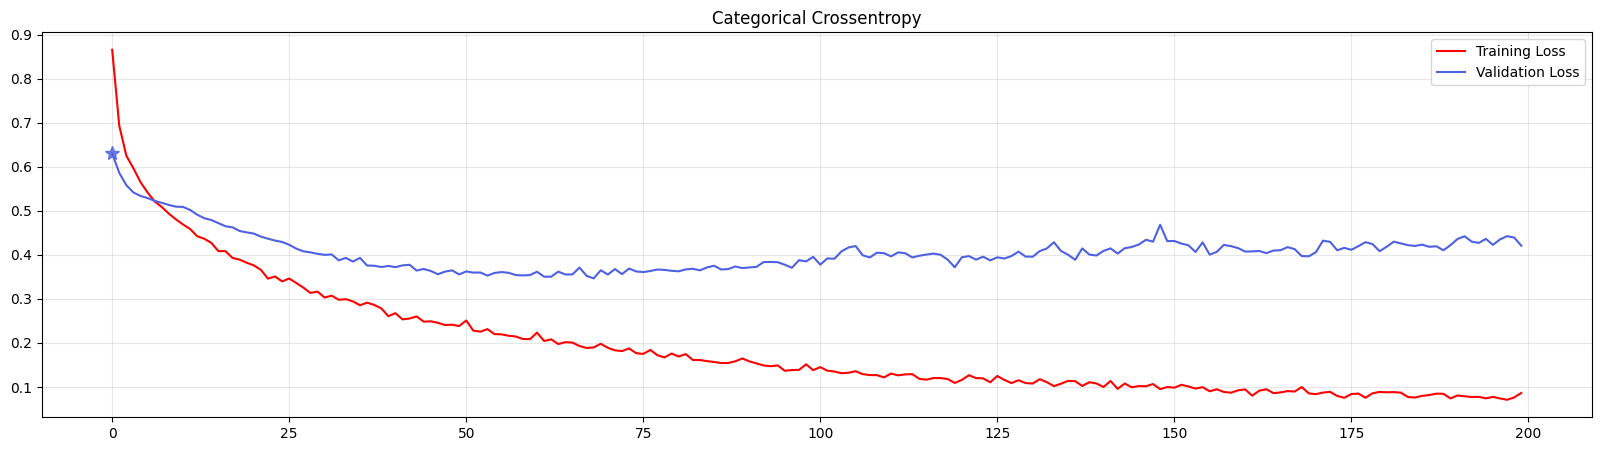

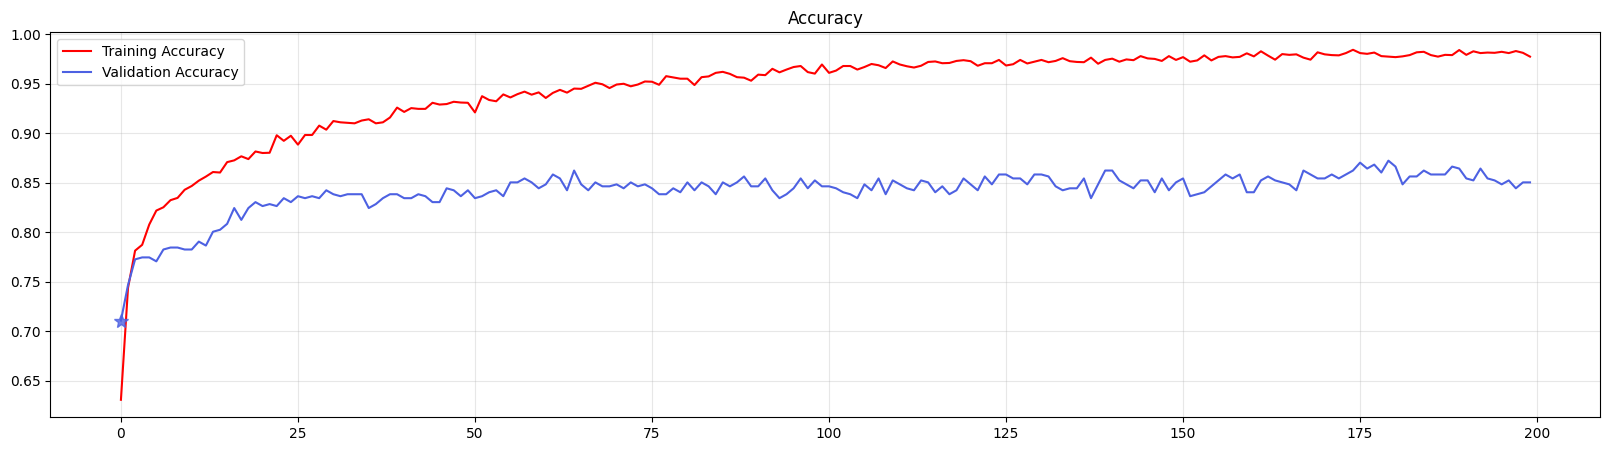

In [29]:
best_epoch = np.argmin(history_EfficientNetV2B2['val_accuracy'])

# Plot the re-trained and the transfer learning EfficientNetV2B2 training histories
plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2B2['loss'], color='#FF0000', label='Training Loss')
plt.plot(history_EfficientNetV2B2['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history_EfficientNetV2B2['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2B2['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history_EfficientNetV2B2['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history_EfficientNetV2B2['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [30]:
# Training of EfficientNetV2B0
history_EfficientNetV2B0 = model_EfficientNetV2B0.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks,
    class_weight=class_weights
).history

all_histories['EfficientNetV2B0'] = history_EfficientNetV2B0

Epoch 1/200
8/8 [==============================] - 15s 468ms/step - loss: 0.9809 - accuracy: 0.6587 - val_loss: 0.6890 - val_accuracy: 0.7106
Epoch 2/200
8/8 [==============================] - 1s 100ms/step - loss: 0.8070 - accuracy: 0.7415 - val_loss: 0.6367 - val_accuracy: 0.7545
Epoch 3/200
8/8 [==============================] - 1s 107ms/step - loss: 0.7339 - accuracy: 0.7808 - val_loss: 0.6221 - val_accuracy: 0.7645
Epoch 4/200
8/8 [==============================] - 1s 108ms/step - loss: 0.6861 - accuracy: 0.8031 - val_loss: 0.6064 - val_accuracy: 0.7685
Epoch 5/200
8/8 [==============================] - 1s 101ms/step - loss: 0.6522 - accuracy: 0.8208 - val_loss: 0.5908 - val_accuracy: 0.7745
Epoch 6/200
8/8 [==============================] - 1s 109ms/step - loss: 0.6325 - accuracy: 0.8262 - val_loss: 0.5859 - val_accuracy: 0.7685
Epoch 7/200
8/8 [==============================] - 1s 131ms/step - loss: 0.6176 - accuracy: 0.8321 - val_loss: 0.5771 - val_accuracy: 0.7764
Epoch 8/200


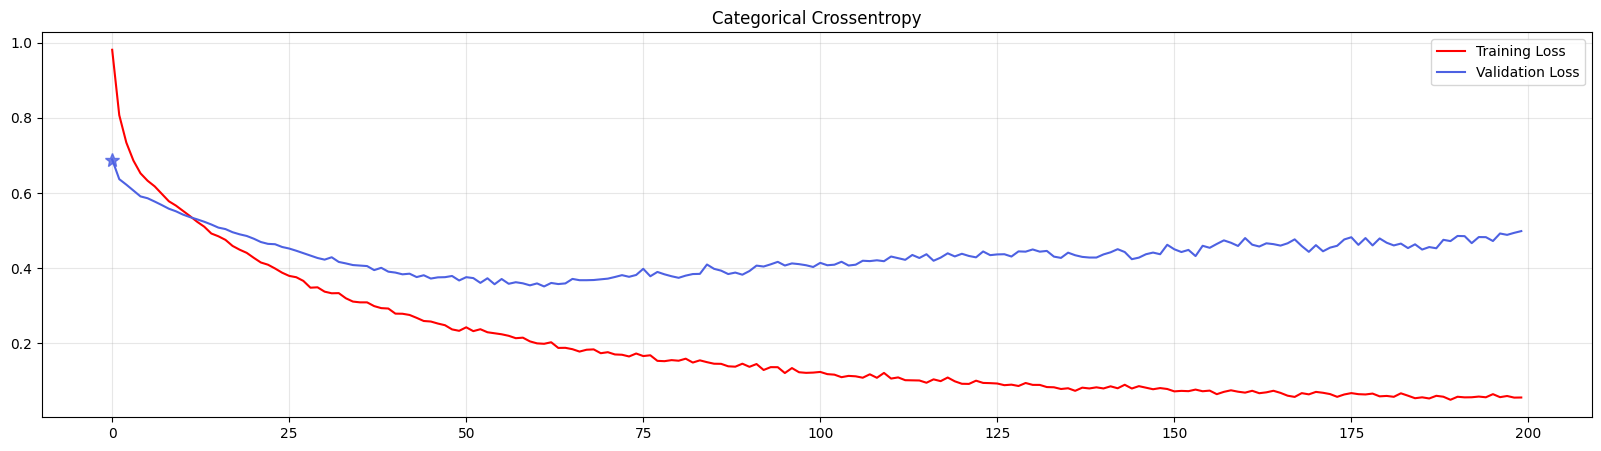

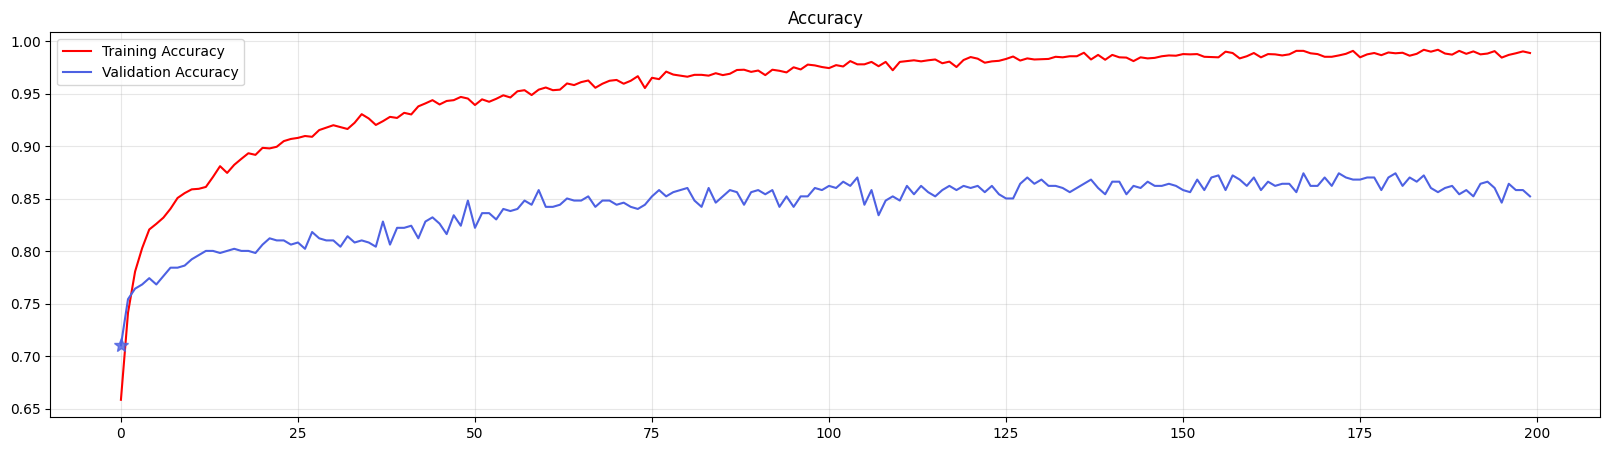

In [31]:
best_epoch = np.argmin(history_EfficientNetV2B0['val_accuracy'])

# Plot the re-trained and the transfer learning EfficientNetV2B2 training histories
plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2B0['loss'], color='#FF0000', label='Training Loss')
plt.plot(history_EfficientNetV2B0['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history_EfficientNetV2B0['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2B0['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history_EfficientNetV2B0['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history_EfficientNetV2B0['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [32]:
# Training of EfficientNetV2S
history_EfficientNetV2S = model_EfficientNetV2S.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks,
    class_weight=class_weights
).history

all_histories['EfficientNetV2S'] = history_EfficientNetV2S

Epoch 1/200
8/8 [==============================] - 30s 1s/step - loss: 0.9519 - accuracy: 0.5582 - val_loss: 0.7236 - val_accuracy: 0.4551
Epoch 2/200
8/8 [==============================] - 2s 225ms/step - loss: 0.7915 - accuracy: 0.6790 - val_loss: 0.6641 - val_accuracy: 0.6487
Epoch 3/200
8/8 [==============================] - 2s 212ms/step - loss: 0.7194 - accuracy: 0.7362 - val_loss: 0.6284 - val_accuracy: 0.7265
Epoch 4/200
8/8 [==============================] - 2s 208ms/step - loss: 0.6820 - accuracy: 0.7574 - val_loss: 0.6089 - val_accuracy: 0.7545
Epoch 5/200
8/8 [==============================] - 2s 209ms/step - loss: 0.6535 - accuracy: 0.7669 - val_loss: 0.5952 - val_accuracy: 0.7585
Epoch 6/200
8/8 [==============================] - 2s 237ms/step - loss: 0.6288 - accuracy: 0.7826 - val_loss: 0.5850 - val_accuracy: 0.7605
Epoch 7/200
8/8 [==============================] - 2s 247ms/step - loss: 0.6067 - accuracy: 0.7869 - val_loss: 0.5786 - val_accuracy: 0.7585
Epoch 8/200
8/8

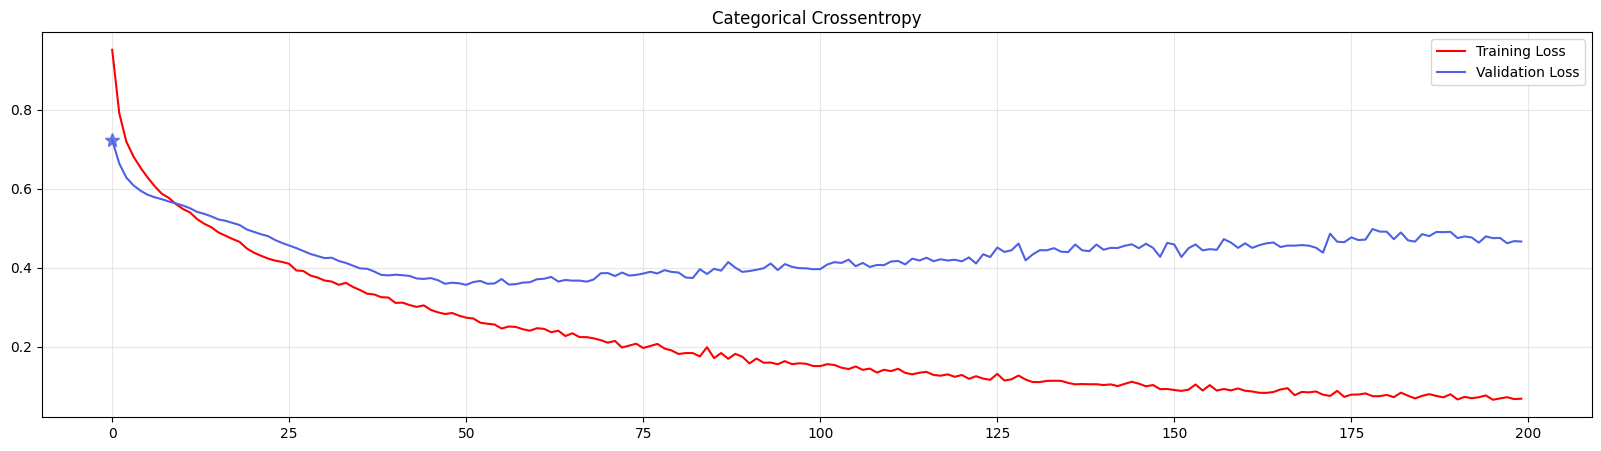

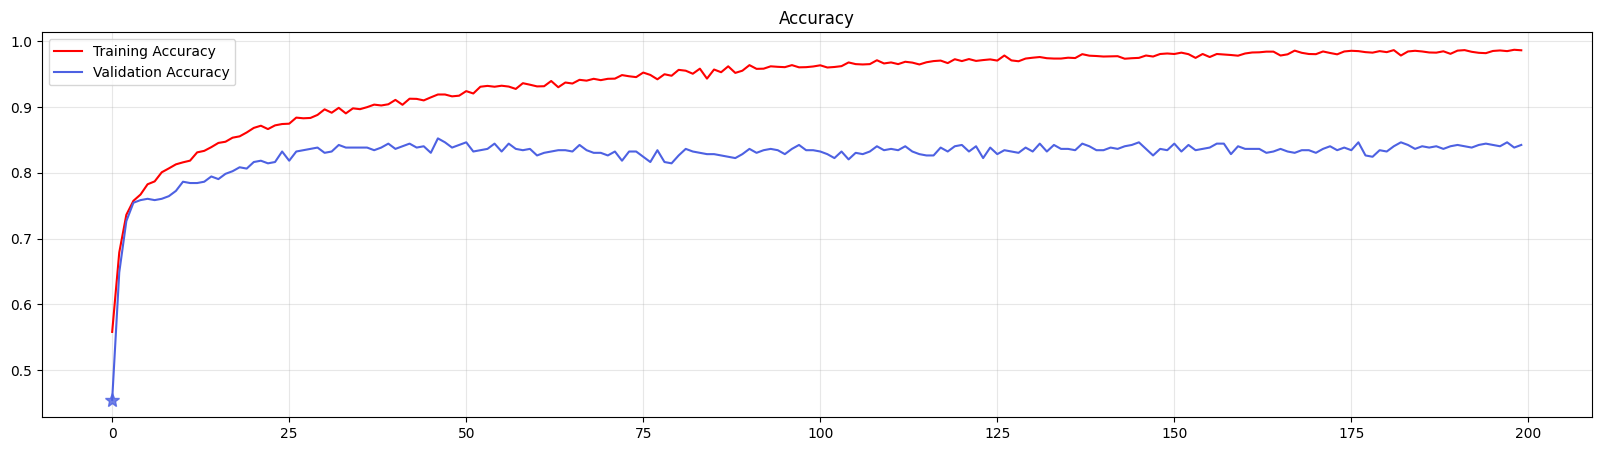

In [33]:
best_epoch = np.argmin(history_EfficientNetV2S['val_accuracy'])

# Plot the re-trained and the transfer learning EfficientNetV2B2 training histories
plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2S['loss'], color='#FF0000', label='Training Loss')
plt.plot(history_EfficientNetV2S['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history_EfficientNetV2S['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2S['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history_EfficientNetV2S['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history_EfficientNetV2S['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [34]:
# Training of EfficientNetV2M
history_EfficientNetV2M = model_EfficientNetV2M.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks,
    class_weight=class_weights
).history

all_histories['EfficientNetV2M'] = history_EfficientNetV2M

Epoch 1/200
8/8 [==============================] - 35s 1s/step - loss: 0.9393 - accuracy: 0.6662 - val_loss: 0.6831 - val_accuracy: 0.6906
Epoch 2/200
8/8 [==============================] - 3s 323ms/step - loss: 0.7858 - accuracy: 0.7264 - val_loss: 0.6538 - val_accuracy: 0.7126
Epoch 3/200
8/8 [==============================] - 3s 321ms/step - loss: 0.7163 - accuracy: 0.7605 - val_loss: 0.6323 - val_accuracy: 0.7545
Epoch 4/200
8/8 [==============================] - 3s 331ms/step - loss: 0.6742 - accuracy: 0.7821 - val_loss: 0.6147 - val_accuracy: 0.7585
Epoch 5/200
8/8 [==============================] - 3s 349ms/step - loss: 0.6509 - accuracy: 0.7923 - val_loss: 0.6040 - val_accuracy: 0.7665
Epoch 6/200
8/8 [==============================] - 3s 355ms/step - loss: 0.6249 - accuracy: 0.7982 - val_loss: 0.5933 - val_accuracy: 0.7725
Epoch 7/200
8/8 [==============================] - 3s 326ms/step - loss: 0.6031 - accuracy: 0.8092 - val_loss: 0.5854 - val_accuracy: 0.7705
Epoch 8/200
8/8

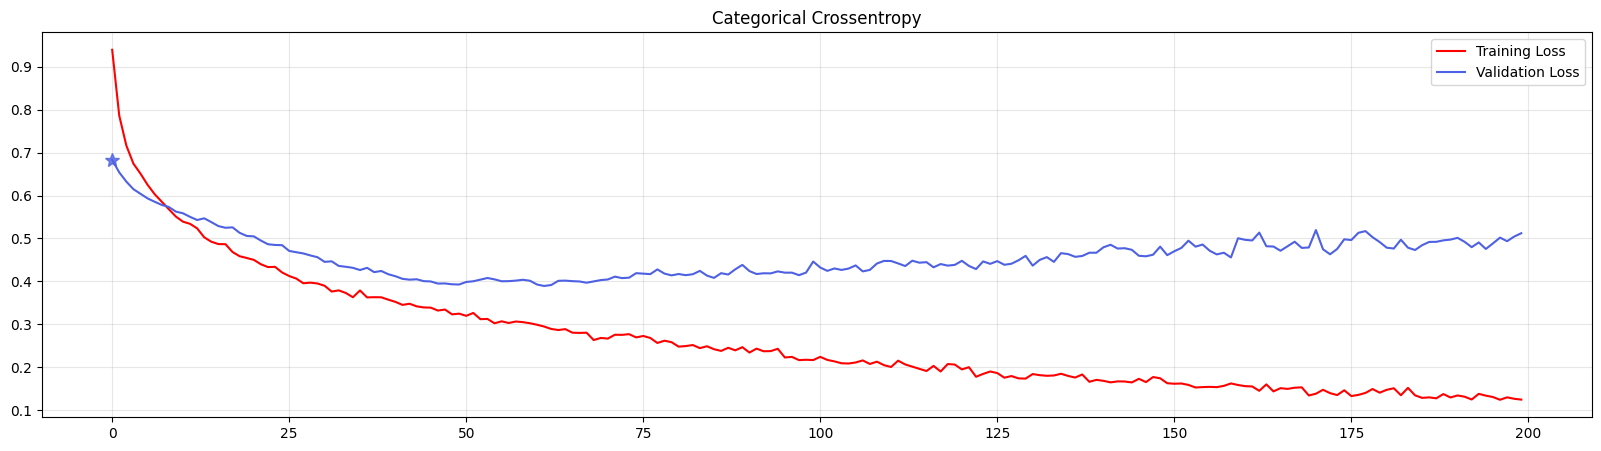

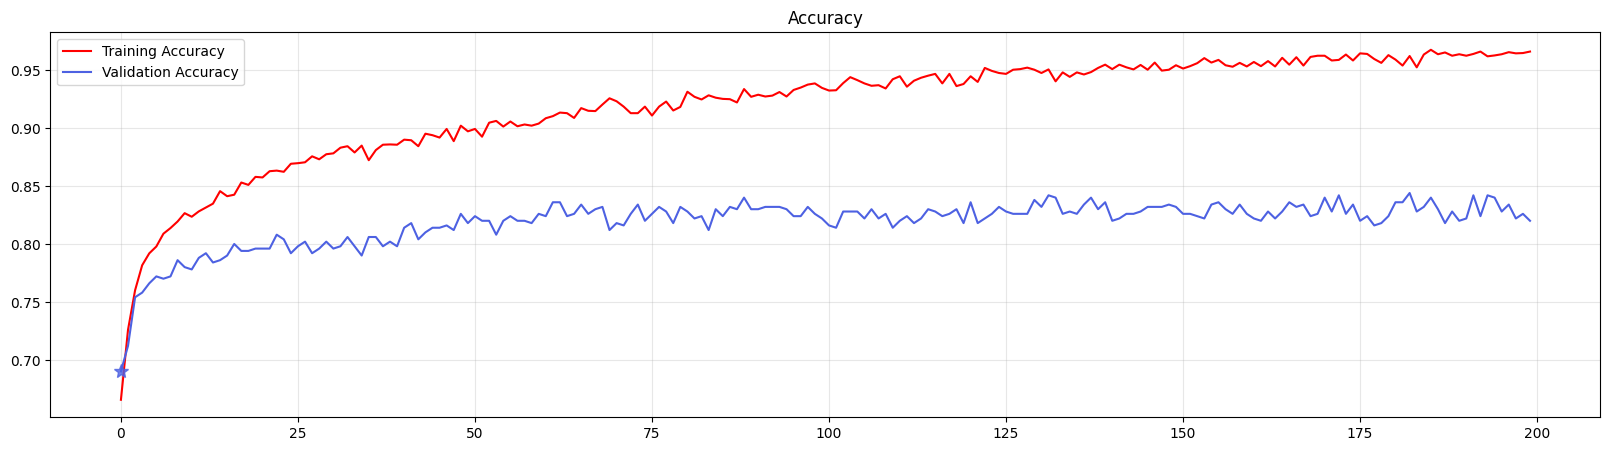

In [35]:
best_epoch = np.argmin(history_EfficientNetV2M['val_accuracy'])

# Plot the re-trained and the transfer learning EfficientNetV2B2 training histories
plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2M['loss'], color='#FF0000', label='Training Loss')
plt.plot(history_EfficientNetV2M['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history_EfficientNetV2M['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history_EfficientNetV2M['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history_EfficientNetV2M['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history_EfficientNetV2M['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [36]:
# Training of MobileNetV2
history_MobileNetV2 = model_MobileNetV2.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks,
    class_weight=class_weights
).history

all_histories['MobileNetV2'] = history_MobileNetV2

Epoch 1/200
8/8 [==============================] - 7s 283ms/step - loss: 0.9052 - accuracy: 0.6197 - val_loss: 0.8320 - val_accuracy: 0.6208
Epoch 2/200
8/8 [==============================] - 1s 107ms/step - loss: 0.8242 - accuracy: 0.6551 - val_loss: 0.7393 - val_accuracy: 0.6208
Epoch 3/200
8/8 [==============================] - 1s 100ms/step - loss: 0.7915 - accuracy: 0.6741 - val_loss: 0.6875 - val_accuracy: 0.6248
Epoch 4/200
8/8 [==============================] - 1s 99ms/step - loss: 0.7709 - accuracy: 0.6838 - val_loss: 0.6665 - val_accuracy: 0.6248
Epoch 5/200
8/8 [==============================] - 1s 106ms/step - loss: 0.7561 - accuracy: 0.6928 - val_loss: 0.6499 - val_accuracy: 0.6267
Epoch 6/200
8/8 [==============================] - 1s 102ms/step - loss: 0.7398 - accuracy: 0.7010 - val_loss: 0.6392 - val_accuracy: 0.6287
Epoch 7/200
8/8 [==============================] - 1s 124ms/step - loss: 0.7251 - accuracy: 0.7077 - val_loss: 0.6338 - val_accuracy: 0.6267
Epoch 8/200
8/

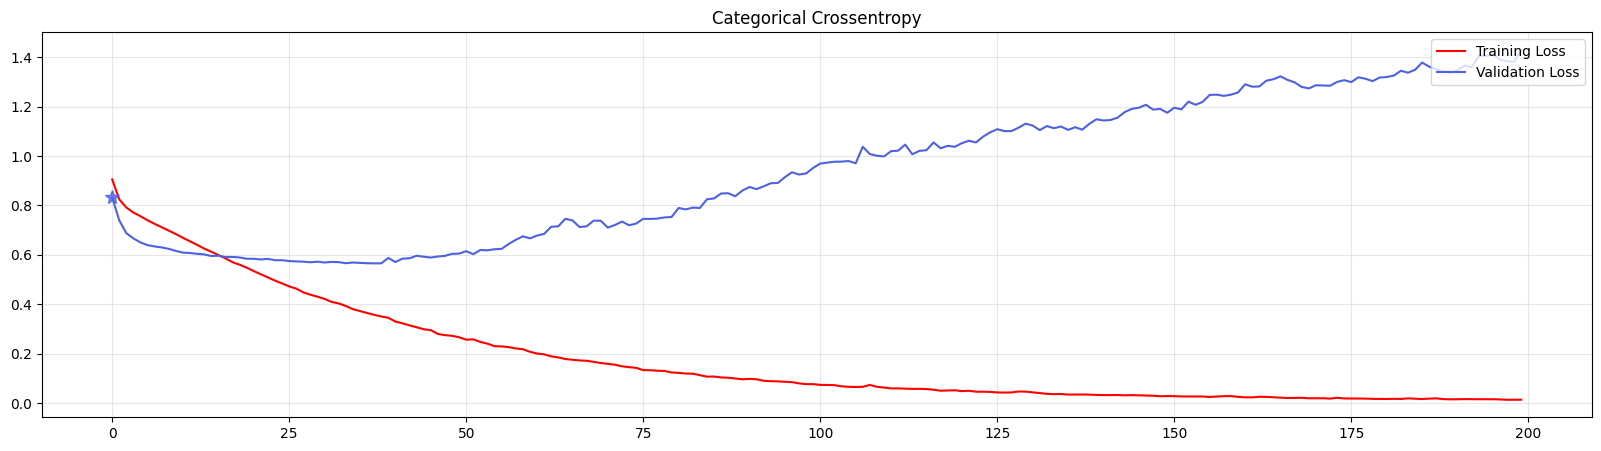

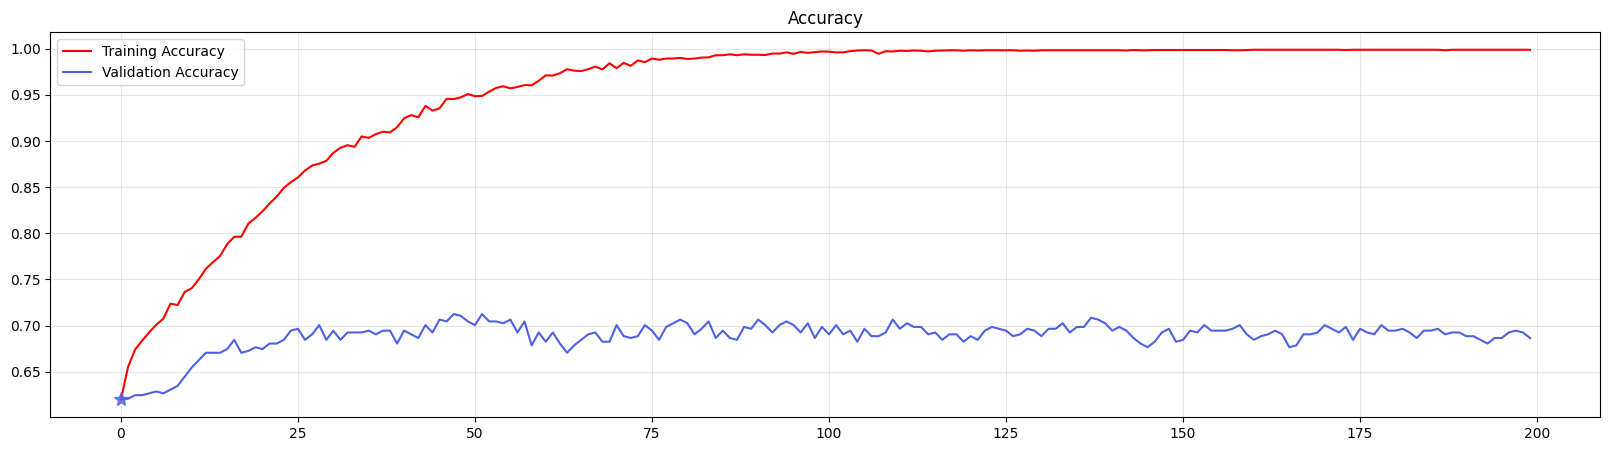

In [37]:
best_epoch = np.argmin(history_MobileNetV2['val_accuracy'])

# Plot the re-trained and the transfer learning EfficientNetV2B2 training histories
plt.figure(figsize=(20,5))
plt.plot(history_MobileNetV2['loss'], color='#FF0000', label='Training Loss')
plt.plot(history_MobileNetV2['val_loss'], color='#4D61E2', label='Validation Loss')
plt.plot(best_epoch, history_MobileNetV2['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper right')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history_MobileNetV2['accuracy'], color='#FF0000', label='Training Accuracy')
plt.plot(history_MobileNetV2['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
plt.plot(best_epoch, history_MobileNetV2['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

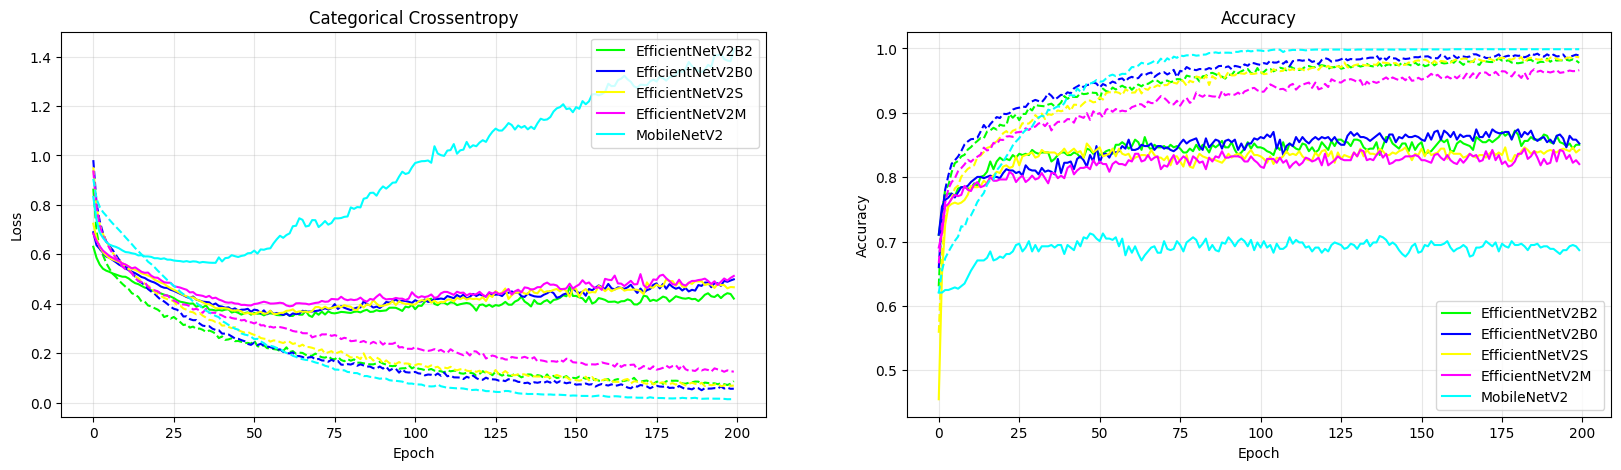

In [41]:
# Now we will show all networks in the same graph in order to obtain a better comparison
# Plotting
colors = ['#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000', '#008080', '#800080']

i = 0

# Initialize figures for Loss and Accuracy
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)  # First subplot for loss
plt.title('Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=.3)

plt.subplot(1, 2, 2)  # Second subplot for accuracy
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=.3)

for model_name, history in all_histories.items():
  if (i > 8):
      i = 0

  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], color=colors[i], linestyle='--')
  plt.plot(history['val_loss'], color=colors[i], label=f'{model_name}')
  plt.legend(loc='upper right')
  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], color=colors[i], linestyle='--')
  plt.plot(history['val_accuracy'], color=colors[i], label=f'{model_name}')
  plt.legend(loc='lower right')

  i += 1

plt.show()

##Testing

In [39]:
# Evaluate the model on the validation set
validation_accuracy = model_EfficientNetV2B2.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy of EfficientNetV2B2: %.4f' % validation_accuracy)
validation_accuracy = model_EfficientNetV2B0.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy of EfficientNetV2B0: %.4f' % validation_accuracy)
validation_accuracy = model_EfficientNetV2S.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy of EfficientNetV2S: %.4f' % validation_accuracy)
validation_accuracy = model_EfficientNetV2M.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy of EfficientNetV2M: %.4f' % validation_accuracy)
validation_accuracy = model_MobileNetV2.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy of MobileNetV2: %.4f' % validation_accuracy)

# Evaluate the model on the test set
test_accuracy = model_EfficientNetV2B2.evaluate(preprocess_input((X_test)),y_test,verbose=0)[-1]
print('Test set accuracy of EfficientNetV2B2: %.4f' % test_accuracy)
test_accuracy = model_EfficientNetV2B0.evaluate(preprocess_input((X_test)),y_test,verbose=0)[-1]
print('Test set accuracy of EfficientNetV2B0: %.4f' % test_accuracy)
test_accuracy = model_EfficientNetV2S.evaluate(preprocess_input((X_test)),y_test,verbose=0)[-1]
print('Test set accuracy of EfficientNetV2S: %.4f' % test_accuracy)
test_accuracy = model_EfficientNetV2M.evaluate(preprocess_input((X_test)),y_test,verbose=0)[-1]
print('Test set accuracy of EfficientNetV2M: %.4f' % test_accuracy)
test_accuracy = model_MobileNetV2.evaluate(preprocess_input((X_test)),y_test,verbose=0)[-1]
print('Test set accuracy of MobileNetV2: %.4f' % test_accuracy)

Validation set accuracy of EfficientNetV2B2: 0.8503
Validation set accuracy of EfficientNetV2B0: 0.8523
Validation set accuracy of EfficientNetV2S: 0.8423
Validation set accuracy of EfficientNetV2M: 0.8224
Validation set accuracy of MobileNetV2: 0.6866
Test set accuracy of EfficientNetV2B2: 0.8583
Test set accuracy of EfficientNetV2B0: 0.8663
Test set accuracy of EfficientNetV2S: 0.8543
Test set accuracy of EfficientNetV2M: 0.8463
Test set accuracy of MobileNetV2: 0.6527
